In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Project 1 - Lyft Bay Wheels Promotion Recommendations

## Introduction

Lyft Bay Wheels was created in 2013, a bikeshare company bought from Ford GoBike. With several competitors in the bay area Lyft has attempted to increase ridership to grow their marketshare of bikeshare riders. To help achieve this goal I have conducted a detailed analysis on Lyft bike data consisting of every Lyft bikeshare trip starting from 2013.

The two main questions I am going to answer:

- What are the 5 most popular commuter trips?
- What promotions should Lyft Bay Wheels offer to increase their ridership?

## Top 5 commuter Trips EDA

Below is my query for the top 5 commuter trips. To define a commuter trip I used the where clause to filter on <b>length of trip</b>, <b>day of week</b>, and <b>hour of trip</b>. I will visualize why I made these decisions.

- <b>Length of Trip</b>
    - Considering the length of a trip time (in minutes) is important because we want to narrow down the trips that are taken for commuting purposes rather than leisure. To do this I broke the trip length into categories of 10 minute intervals and then group by subscriber type. This will show us what type of trips customers and subscribers take. Looking at the bar chart, the subscribers take shoers trips, with most under 10 minutes and essentially all of them under 20 minutes. I will filter by this when finding the commuter trips. Customer trips are more evenly spread out with a surprising peak at greater than 50 minutes.

In [23]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type,duration_min AS duration_min_range,COUNT(*) AS count FROM `sep-2020.bike_trip_data.duration_min2` GROUP BY duration_min, subscriber_type ORDER BY count ' > trip_time.csv
trip_time = pd.read_csv('trip_time.csv')
ranges = ['< 10','10-20','20-30','30-40','40-50','> 50']
def time_ranges(x):
    for i in range(6):
        if x == i:
            return ranges[i]
trip_time['ranges']=trip_time['duration_min_range'].apply(time_ranges)

mapping = {time: i for i, time in enumerate(ranges)}
key = trip_time['ranges'].map(mapping)
trip_time = trip_time.iloc[key.argsort()]
trip_time=trip_time.sort_values(by=['duration_min_range','count'],ascending=[True, False])

Waiting on bqjob_r4a9966e41e20ebbd_00000174d2f51c11_1 ... (0s) Current status: DONE   


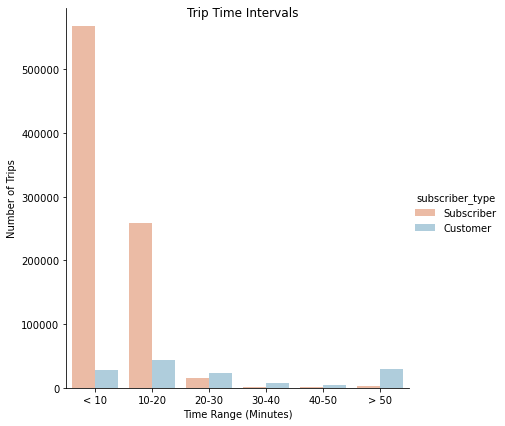

In [24]:
g = sns.catplot(
    data=trip_time, kind="bar",
    x="ranges", y="count", hue="subscriber_type", palette="RdBu", height=6
)
g.set_axis_labels("Time Range (Minutes)", "Number of Trips")
g.fig.suptitle('Trip Time Intervals');

- <b>Day Of Week</b>
    - Day of the week will help us narrow down which days we want to look at when considering commuter trips. Looking at the bar chart you can see that on the week days the subscribers take an overwhelming amount more trips than customers. I will filter out weekends when searching for the top 5 commuter trips. It is interesting to note that customer trips increase on the weekends.

In [4]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, dow_str, COUNT(*) AS count FROM `sep-2020.bike_trip_data.trips_with_days` GROUP BY subscriber_type, dow_str ' > days.csv
days = pd.read_csv('days.csv')

dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(dow)}
key = days['dow_str'].map(mapping)
days = days.iloc[key.argsort()]

Waiting on bqjob_r5e9ebd9cf9b571e3_00000174d2f1cab6_1 ... (0s) Current status: DONE   


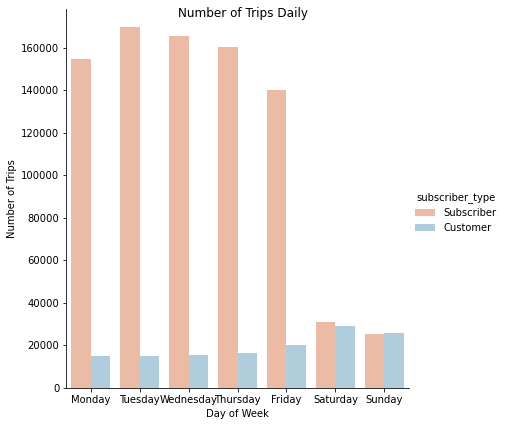

In [5]:
g = sns.catplot(
    data=days, kind="bar",
    x='dow_str', y="count", hue="subscriber_type", palette="RdBu", height=6
)
g.set_axis_labels("Day of Week", "Number of Trips")
g.fig.suptitle('Number of Trips Daily');

- <b>Hour of Trip</b>
    - Hour of trip is important when you are narrowing down commuter trips since we want to only look at the trips taken when people are riding bikes to and from work. These hours are most likely between 6 and 9 AM and 4 and 6 PM, but lets query some data and get an exact result. Looking at the graph below we can see the subscriber trips skyrocket around commuting hours. I will use 7, 8, 9 as morning commuting hours and 16, 17, 18 as night commuting hours. Its also important to note the customer trips do not have a spike in the morning and night like subscribers do. This leads me to believe they do not take an commuter trips and we can filter out all customers in our search for commuter trips. The table I print out shows that the least busy times are between 5-7 AM for customers.

In [6]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, start_hour, COUNT(*) AS number FROM `sep-2020.bike_trip_data.trips_with_days2` GROUP BY subscriber_type, start_hour order by start_hour ' > hours.csv
hours = pd.read_csv('hours.csv')
hours = hours[(hours['start_hour']>4) & (hours['start_hour']<22)]

print('Hours of Lowest Traffic')

hours.sort_values(by='number',ascending=True).head(5)

Waiting on bqjob_r3cc98ec3895a8e86_00000174d2f1d3a8_1 ... (0s) Current status: DONE   
Hours of Lowest Traffic


,subscriber_type,start_hour,number
11,Customer,5,303
13,Customer,6,945
15,Customer,7,2585
42,Customer,21,2808
41,Customer,20,3741


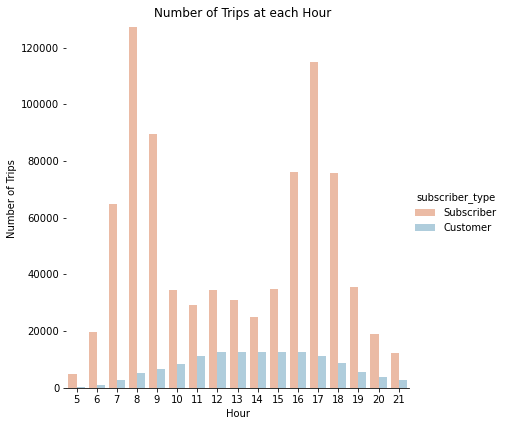

In [7]:
g = sns.catplot(
    data=hours, kind="bar",
    x='start_hour', y="number", hue="subscriber_type", palette="RdBu", height=6
)
g.despine(left=True)
g.set_axis_labels("Hour", "Number of Trips")
g.fig.suptitle('Number of Trips at each Hour');

## Top 5 Commuter Trips

Putting this all together we see the top 5 commuter trips. From the original data I filtered by length of trip, day of week, and hour of trip. I explained the reasoning for these above. I also filtered by subscriber type, eliminating all customers. From the analysis throughout this project and researching on the lyft website it was clear if you are taking commuter trips it is very likely you are already a subscriber. I also made sure the start and end station were not the same, or else this would not be a commute. Lastly, I made sure the trip length was greater than 2 minutes. I did this because I wanted to filter out misleading data where the user possible took the bike out and then returned it. Below are the top 5 commuting trips from our database.

In [8]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT start_station_name, end_station_name, COUNT(*) AS commuter_trips FROM `sep-2020.bike_trip_data.trips_with_days2` WHERE dow_weekday="Weekday" AND duration_sec<=1200 AND duration_sec>60 AND (commute="Morning Commute" OR commute="Night Commute") AND subscriber_type="Subscriber" AND start_station_name!=end_station_name GROUP BY start_station_name, end_station_name ORDER BY commuter_trips DESC Limit 5'  > commuter_trips.csv
commuter_trips = pd.read_csv('commuter_trips.csv')
commuter_trips

Waiting on bqjob_r4468c2d0428b8f82_00000174d2f1dd3d_1 ... (0s) Current status: DONE   


,start_station_name,end_station_name,commuter_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5006
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4932
2,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4849
3,Embarcadero at Sansome,Steuart at Market,4684
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4672


## Promotions Recommendation EDA

- <b>Start and End Stations the Same</b>
    - Looking at how many of the trips start and end at the same station is interesting when broken up between subscribers and non subscribers. Subscribers end at the same station they start at around 1% while customers are all the way up at 16%. This means that subscribers nearly always use their trips to go somewhere, while customers may be using it for more of a leisure trip and returning to the same station. Giving customers the mind set that they can use Lyft Bay Wheel bikes to commute will be a breakthrough in marketshare.

In [9]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT subscriber_type, start_station_is_end_station, COUNT(*) as number FROM `sep-2020.bike_trip_data.start_station_is_end_station` GROUP BY subscriber_type, start_station_is_end_station '  > stations.csv
stations = pd.read_csv('stations.csv')
stations

Waiting on bqjob_r60a631896ca1843d_00000174d2f1e4fe_1 ... (0s) Current status: DONE   


,subscriber_type,start_station_is_end_station,number
0,Customer,1,22153
1,Subscriber,1,9894
2,Subscriber,0,836945
3,Customer,0,114656


In [10]:
print('Percent of trips starting and ending at the same station for subscribers are {0}%'.format(1.2))
print('Percent of trips starting and ending at the same station for customers are {0}%'.format(16.2))

Percent of trips starting and ending at the same station for subscribers are 1.2%
Percent of trips starting and ending at the same station for customers are 16.2%


- <b>Weekend Hours</b>
    - The subscribers and customers follow a similar distribution for number of rides per hour over the weekends. It is interesting to note that there are far fewer rides in the early morning. A promotion targeting weekend mornings allowing for longer rides will be a great way to get riders to ride to new stations and expand their network of rides without taking too many bikes away from other users.

In [11]:
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=1000000 'SELECT subscriber_type, start_hour, COUNT(*) AS number FROM `sep-2020.bike_trip_data.trips_with_days2` WHERE dow_weekday="Weekend" GROUP BY subscriber_type, start_hour order by number '  > hours_weekend.csv
hours_weekend=pd.read_csv('hours_weekend.csv')

Waiting on bqjob_r1b5d7b50bf97a4b7_00000174d2f1ec7a_1 ... (0s) Current status: DONE   


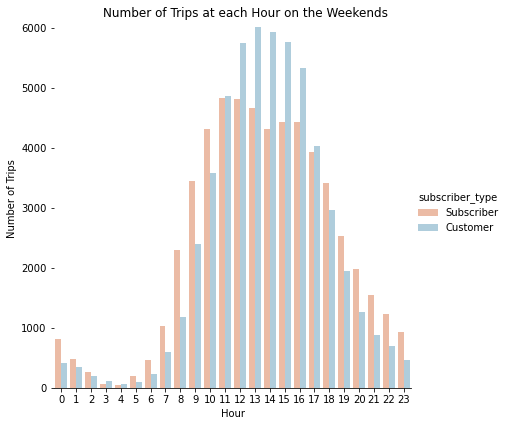

In [12]:
g = sns.catplot(
    data=hours_weekend, kind="bar",
    x='start_hour', y="number", hue="subscriber_type", palette="RdBu", height=6
)
g.despine(left=True)
g.set_axis_labels("Hour", "Number of Trips")

g.fig.suptitle('Number of Trips at each Hour on the Weekends');

##  Recommendations for Offers

Based off my findings I have a few recommendations. My recommendations are focused on increasing customers base since there are already a large number of subscribers. If the promotions are successful then more customers will convert to subscribers and we will still want more customers. I am narrowing in on weekends since there are high bike availabilities, most bikes are used during weekdays and commuting hours. 

- <b>Keep</b>
    - 45 Minute Rides for Members (30 Minutes for non members). 
        - This is a great promotion since there is a small population of riders that ride longer than 20 minutes. Allowing rides to be 45 minutes rather than 30 will not effect the majority of our riders (commuters) and will be apealing to customers since they favor longer rides.



- <b>Add</b>
    - First ride free outside of commuting hours (Weekdays 7-9 AM and 4-6 PM). 
        - This will increase the number of people that try out the bikes without taking away from subscribers available bikes since it is outside of commuter hours.
    - Increase the ride time for customer rides that start before 9 AM on the weekends to 50 minutes.
        - Not many customers take trips in the mornings on the weekends so this would be a perfect promotion to target a low ride time. Additionally, most of customer trips are less than 20 or greater than 50, so offering customers longer rides without missing out on extra money if rides go longer than 50 minutes.
    - Weekend Ride Pass
        - Offer a package of 10 30-minute rides that can be used on weekends only for 10$ (this is half what it would cost otherwise). This also increases ridership.
    - 15% off rides that end at a different than they started at
        - This encourages Customers to ride to other stations and start commuting places rather than using the bikes for leisure trips. Seeing the table below it looks like subscribers are using their trips to get from one place to another but 15% of customers still end at the same station they started at.

# Appendix

### -Days

In [13]:
"""%%bigquery trips_with_days_table

SELECT *,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN 'Sunday'
           WHEN 2 THEN 'Monday'
           WHEN 3 THEN 'Tuesday'
           WHEN 4 THEN 'Wednesday'
           WHEN 5 THEN 'Thursday'
           WHEN 6 THEN 'Friday'
           WHEN 7 THEN 'Saturday'
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN 'Weekend'
           ELSE 'Weekday'
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN 'Nightime'
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN 'Morning'
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN 'Mid Morning'
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN 'Mid Day'
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN 'Early Afternoon'
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN 'Afternoon'
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN 'Evening'
           END AS start_hour_str
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY start_date ASC""";

### -Length of Trip

In [14]:
"""%%bigquery trip_time_table
SELECT *,
       CASE 
           WHEN duration_sec <= 600 THEN 0
           WHEN duration_sec > 600 and duration_sec <= 1200 THEN 1
           WHEN duration_sec > 1200 and duration_sec <= 1800 THEN 2
           WHEN duration_sec > 1800 and duration_sec <= 2400 THEN 3
           WHEN duration_sec > 2400 and duration_sec <= 3000 THEN 4
           WHEN duration_sec > 3000 THEN 5
           END AS duration_min,
        CASE 
           WHEN duration_sec <= 600 THEN 't < 10'
           WHEN duration_sec > 600 and duration_sec <= 1200 THEN '10 < t < 20'
           WHEN duration_sec > 1200 and duration_sec <= 1800 THEN '20 < t < 30'
           WHEN duration_sec > 1800 and duration_sec <= 2400 THEN '30 < t < 40'
           WHEN duration_sec > 2400 and duration_sec <= 3000 THEN '40 < t < 50'
           WHEN duration_sec > 3000 THEN 't > 50'
           END AS duration_min_str
FROM `bigquery-public-data.san_francisco.bikeshare_trips`""";

### -Commute

In [15]:
"""%%bigquery commute
SELECT *,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) >= 7  and EXTRACT(HOUR FROM start_date) <= 9 THEN "Morning Commute"
           WHEN EXTRACT(HOUR FROM start_date) >= 16 and EXTRACT(HOUR FROM start_date) <= 18 THEN "Night Commute"
           ELSE 'None'
           END AS commute
FROM `bigquery-public-data.san_francisco.bikeshare_trips`""";

### - Start station and end station the same

In [16]:
"""%%bigquery start_station_is_end_station
SELECT
  *,
  CASE
    WHEN start_station_name=end_station_name THEN 1
    WHEN start_station_name<>end_station_name THEN 0
END
  AS start_station_is_end_station,
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`""";